# Natural Language Processing - Group Assignment Task 2
## Group 6
##### Robert Brunnsteiner, Mohammad Mahdi Fallah, Akshey Kumar, Jan-Jonas Schumacher
VU Data Mining (WS 2021/22)

The assignment was done by our group of four, since one of the original members left at the beginning of this course.

### Task:

Task-2 is about exploring the potential of CNNs (Convolutional Neural Networks) for text classification and more specifically for sentiment analysis [12]. The generic CNN architecture you need to use is depicted in Figure 1. The dataset to be used is the IMDB Movie review dataset described in [16]. It consists of 25 000 positive and 25 000 negative movie reviews and is available for free. There are also 50 000 unlabeled samples which will not be used for this task. After extracting the downloaded archive, you should collect the texts of each file, organize them as a dataframe and store it as a CSV file. For this, you can run the code of Listing 1 on the same path where you have aclImdb folder.

## Imports and requirements

In [1]:
#decomment to use pip to install all the requirements!
#!pip install -r requirements.txt

In [13]:
# Task 2a
import os
import pandas as pd
from sklearn.utils import shuffle 
import string, nltk
from nltk.tokenize import RegexpTokenizer
import re

# Task 2b and 2c
import numpy as np
import random, sys
import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Conv1D, GlobalMaxPooling1D, MaxPooling1D, AveragePooling1D, Flatten, Concatenate, LeakyReLU, Dropout
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.utils import plot_model 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
import pydot
import graphviz
import matplotlib.pyplot as plt
import keras_tuner as kt
from IPython.display import Image

## NLP Task 2-a
Task: In this step you will perform preprocessing of the review part of each data sample. Start by printing the raw review field of a dataframe sample with index X (you pick X yourself). Then, write a function to preprocess the texts and apply it in each review cell of the dataframe entries. The function must lowercase the text. It must also replace every number occurrence (integer or float) with a single ‘#’ symbol. Furthermore, you should make sure to keep (or save and add again) all smiley symbols which are very helpful sentiment polarityanalysis features. Besides‘#’ and smileys, all other punctuation or special symbols must be removed. After applying the function in the entire dataframe print the preprocessed text of the same sample X to show how it changed.

### Our approach:
While lowercasing and replacing numbers by # is straighforward, recognizing smileys so that they don't get discarded as interpunctation is a little bit trickier. We chose to use a RegEx Tokenizer that makes a whitespace.

In [2]:
# Listing 1: Python code for preparing IMDB movie review dataset
labels = {'pos':1, 'neg':0} # data labels
df = pd.DataFrame() # dataframe for holding the samples

# walking through the folder structure
for s in ('test', 'train'): 
    for l in ('pos', 'neg'):
        path ='./aclImdb/%s/%s' % (s, l) 
        for file in os.listdir (path):
            with open(os.path.join(path, file), 'r', encoding='utf8') as infile:
                txt = infile.read () # read content of each file
            df = df.append([[txt , labels[l]]], ignore_index=True)

# name of data columns
df.columns = ['review', 'polarity']
# randomly shuffle dataframe samples
df = shuffle(df, random_state=7)
# save dataframe to CSV file
df.to_csv ('./review_samples.csv', index=False)

In [3]:
# preprocess function
def preprocess(dataset):
    rows = dataset.shape[0]
    
    #this tokenizer takes words, the # symbol and smilies as tokens and discards the rest
    tokenizer = RegexpTokenizer(r'\w+|#|(?::|;|=)(?:-)?(?:\)|\(|\\|\/|D|P)')
    
    #loop over all rows and preprocess the reviews
    for i in range(rows):
        # text to lower case
        dataset.iloc[i, 0] = (dataset.iloc[i, 0]).lower()
        # substitute floats and integers to #
        dataset.iloc[i, 0] = re.sub(r'[+-]?([0-9]*[.])?[0-9]+', '#', dataset.iloc[i, 0])
        # remove punctuation other than # and smilies using the tokenizer defined above
        dataset.iloc[i, 0] = ' '.join(tokenizer.tokenize(dataset.iloc[i, 0]))

In [4]:
data = pd.read_csv('review_samples.csv')
preprocess(data)
data.to_csv ('./review_preprocessed.csv', index=False)

### Results:
Below, we show the result of the preprocessing of one sample review. The number and smiley handling can be seen from this example, together with the removal of interpunctation and lowercasing:

In [15]:
raw = pd.read_csv('review_samples.csv')
proc = pd.read_csv('review_preprocessed.csv')

print(raw.iloc[3615, 0])
print('***********************************')
print(proc.iloc[3615, 0])

Sometime I fail to understand what do the directors think when they make a movie... I had had a trauma after watching Welcome (2007) and thought that they wont do it again. But after loads of amazing promos, Tashan finally ended as heart attack.<br /><br />Such amazing 3 songs in promo - Dil Haara, Chhaliya and Tashan Mein..... and what u get in the movie? Zero story, predictable plot, plenty of Akshay Kumar stunts and nothing interesting apart from watching Kareena after her major weight loss...!!!<br /><br />Music-wise another major disaster... in the music album, they have spent time on giving pathetic small dialogs of these 4 jokers and they haven't thought of giving the background song of the scenes when Akshay Kumar is doing stunts...! that song is such nice, quite comparable to Tashan Mein and that is not taken in the music album!!! :-( If you plan to watch this movie, i would say, watch it to listen to that background song which goes something like ...'Bachchan Bachchan Pandey.

## NLP Task 2-b
Task: In this step you will implement a “vanilla” model of the architecture. 
For this you will need to use PyTorch or Tensorflow/Keras functional API and various layers
like Input, Embedding, Conv1D, Dropout, MaxPooling1D, Flatten, concatenate, Dense, etc. as well as
other utility functions such as Tokenizer. For some of the parameters, you should consider the values
suggested in Table 1. Please note that those values are “typical” but not necessarily optimal. First, you need to tokenize the texts and cut/pad them to a common max length size. Then you derive the train and test samples and labels. The “vanilla” model should contain the Embedding layer, a single convolution layer of only one block followed by a max-pooling layer and a single dense layer. You will report the classification accuracy of this model.


### Our approach:

In this task we created a basic vanilla model with and without parameter optimization. For optimization, we used the Keras tuner framework. Before creating the model, we defined the necessary parameters shown in the cell below. Before creating and training the model we prepared the data from task 2a. Therefore, we loaded the 'review_preprocessed.csv' file and split the data in a training and test set using the 'SPLIT_DATA' variable and using the random state for reproducibility. Next, we used the Tensorflow Tokenizer to vectorize a text corpus by turning them into a sequence of integers. Finally, we used Tensorflows pad_sequences to create a common max length by padding or cutting the review entries to a common length specified by the parameter 'UNIFORM_LENGTH'.

Now we were able to create a basic vanilla model to predict the proximity of a movie review. We used the functional API of Keras and created an Input, Embedding, Convolution(1D), MaxPooling, MaxPooling1D, Flatten, Dropout and an Output layer. We added the dropout layer to deal with the overfitting of our model. The model summary is shown below. We compiled the model with the loss 'binary_crossentropy' loss, the 'adam' optimizer and the metrics as 'accuracy'. In the end, we used the fit function with BATCH_SIZE=16 and EPOCHS=3 variables and defined a validation split of 0.2. We evaluated the model with the test data.

We were also interested if the recommended parameters in the cell below would improve our accuracy further. Therefore, we used the Keras tuner framework with a Hyperband search to get more insight. The architecture was identical as before. We performed hyperparameter optimization over the following parameters: LEARNING_RATE, WORD_EMBEDDING_DIM, UNIFORM_LENGTH, CONV_FILTERS, KERNEL_SIZE, DROPOUT. 

The Vocabulary was fixed to 30.000. We did not optimize over the BATCH_SIZE and UNIFORM_LENGHT parameters. 

#### Parameters (Recommendation)

W or number of convolution blocks in each layer: 2-5.  
L or number of consecuetive convolution-pooling layers: 2-4  
Maximal length of each review sequence: 300-500    
Dimension of word embbeddings: 150-300.  
Train : Test split of the data samples: 4:1 or 9:1.  
Number of filters in each convolution layer: 10-50.  
Kernel size in each convolution block: 1-5.  

Here we set up the parameters for our model. Those are standard values that are replaced by other values in the process of optimizing, as can be seen in tasks 2(b) and 2(c).

In [2]:
#  Max lenght of each review sequence
UNIFORM_LENGTH = 300
# The dimension of the word embeddings
WORD_EMBEDDING_DIM = 150
# Train : Test split
SPLIT_DATA = 0.8
# Number of filters in each convolution layer
CONV_FILTERS = 10
# Kernel size in each convolution block
KERNEL_SIZE = 1
# Vocabulary: number of most frequent words
VOCABULARY = 30000
# POOL_SIZE: Downsamples the input representation by taking the maximum value 
POOL_SIZE = 2
# Training and evaluation:
EPOCHS = 3
BATCH_SIZE = 16
VERBOSE = 1

### Loading and preparing data

Loading the pre-processed data and splitting them into train and test sets. Random state is fixed for reproducibility.

In [3]:
df = pd.read_csv('review_preprocessed.csv')
training_data = df.sample(frac=SPLIT_DATA, random_state=25)
testing_data = df.drop(training_data.index)

print(f"No. of training examples: {training_data.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}")

No. of training examples: 40000
No. of testing examples: 10000


In [4]:
### Converting the pandas dataframe to lists and numpy arrays
X_train = training_data.loc[:,'review'].to_list()
X_test = testing_data.loc[:,'review'].to_list()
y_train = training_data.loc[:,'polarity'].to_numpy()
y_test = testing_data.loc[:,'polarity'].to_numpy()

In [5]:
### Variables for original (not vectorized) data
X_train_text = X_train
X_test_text = X_test

The Tokenize class helps us to vectorize a text corpus by tunring them into a sequence of integers. 

In [6]:
t  = Tokenizer(num_words = VOCABULARY)

t.fit_on_texts(X_train)
X_train_enc = t.texts_to_sequences(X_train)
X_test_enc = t.texts_to_sequences(X_test)

Here we force a uniform length for each review. Longer reviews are truncated and shorted reviews and padded with zeros.

In [7]:
X_train_pad = pad_sequences(X_train_enc, maxlen=UNIFORM_LENGTH)
X_test_pad = pad_sequences(X_test_enc, maxlen=UNIFORM_LENGTH)

X_train = X_train_pad
X_test = X_test_pad

### CNN vanilla model 
For implementing the convulution neural networks, we used the functional Keras API of Tensorflow:

In [22]:
inputs = Input(shape=(UNIFORM_LENGTH,))
x = Embedding(VOCABULARY, WORD_EMBEDDING_DIM, input_length=UNIFORM_LENGTH)(inputs)
x = Conv1D(filters=CONV_FILTERS, kernel_size=KERNEL_SIZE, activation='relu')(x)
x = MaxPooling1D(pool_size=POOL_SIZE)(x)
x = Flatten()(x)
x = Dropout(.8)(x)
outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 300, 150)          4500000   
_________________________________________________________________
conv1d (Conv1D)              (None, 300, 10)           1510      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 150, 10)           0         
_________________________________________________________________
flatten (Flatten)            (None, 1500)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1500)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1501  

In [24]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Callback for tensorboard VIS
tb_callback = callbacks.TensorBoard(log_dir="logs/", histogram_freq=1)
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[tb_callback])

Epoch 1/3
2000/2000 [==============================] - 60s 30ms/step - loss: 0.5746 - accuracy: 0.6695 - val_loss: 0.3716 - val_accuracy: 0.8394
Epoch 2/3
2000/2000 [==============================] - 59s 30ms/step - loss: 0.3910 - accuracy: 0.8242 - val_loss: 0.3324 - val_accuracy: 0.8618
Epoch 3/3
2000/2000 [==============================] - 59s 29ms/step - loss: 0.3349 - accuracy: 0.8547 - val_loss: 0.3097 - val_accuracy: 0.8730


In [25]:
# Evaluate Vanilla model
score = model.evaluate(X_test, y_test)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

313/313 [==============================] - 1s 2ms/step - loss: 0.3133 - accuracy: 0.8707
Test loss: 0.3133133053779602 / Test accuracy: 0.8707000017166138


#### Accuracy

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


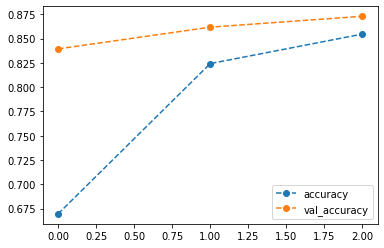

In [26]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'], label = "accuracy", linestyle='--', marker='o')
plt.plot(history.history['val_accuracy'], label = "val_accuracy", linestyle='--', marker='o')
plt.legend()
plt.show()

### Results:

The learning curve shows that the model is well-fit to the data, i.e. it is neither overfit nor underfit. Initially, we encountered overfitting as the training accuracy was much higher than the validation accuracy. To tackle this, we incorporated a dropout layer. Subsequently, the learning curves improved, and as we see, the training and validation accuracy is nearly equal by the second epoch. Classification accuracy of 0.87 on unseen data shows us that our model performs rather well at classifying the reviews.

#### Investigating the missclassified results
Here we investigate what kind of samples are wrongly classified.

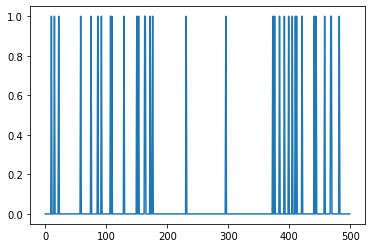

Review: 10
this movie was the most horrible movie watching experience i have ever had to endure and what is worse is the fact that i had to watch it and didn t have the opportunity to stop it because it was for school admittedly the storyline was decent but i found the acting terrible the exception was marianne jean baptiste i thought her performance was wonderful she was the only highlight without her i doubt i would have been able to bear watching the film every time i hear somebody say daarling i cringe i nearly attacked a customer the other day because they said it it made me remember one of the worst one and a half hours of my life br br i apologise if this has offended anybody i am only expressing my opinion
Correct: 0 Prediction: 1
False positive
********************
Review: 15
skip all the subjective this is a great film reviews and read the imdb trailer or the back the kino videobox which includes both versions of this flick which i ll paraphrase to the tune of sci fi score by

/var/folders/5v/wrnrfs9x5z30cjvp_ytqb1pc0000gn/T/ipykernel_52452/3873377048.py:7: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  wrong_class=[X_train_text[i] for i in difference]


In [27]:
amount = 500
ypred = (model(X_train[:amount]).numpy() > 0.5).astype(int).reshape(amount)
difference =  ypred != y_train[:amount]
plt.plot(difference)
plt.show()
wrong_idx = list(np.where(difference)[0])
wrong_class=[X_train_text[i] for i in difference]
False_negative = 0
False_positive = 0
for i in range(0, len(wrong_idx)):
    
    print("Review:", wrong_idx[i])
    print(X_train_text[i])
    print("Correct:", y_train[wrong_idx[i]], "Prediction:",  ypred[wrong_idx[i]])
    if(y_train[wrong_idx[i]] == 1):
        print("False negative")
        False_negative += 1
    if(y_train[wrong_idx[i]] == 0):
        print("False positive")
        False_positive += 1
    print("********************")
    


20 13


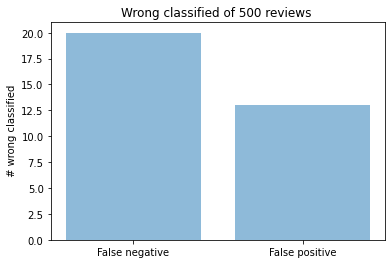

In [28]:
print(False_negative, False_positive)
objects = ('False negative', 'False positive')
y_pos = np.arange(len(objects))
performance = [False_negative, False_positive]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel(' # wrong classified')
plt.title(f'Wrong classified of {amount} reviews ')

plt.show()

### CNN vanilla model with keras tuner

In [29]:
def call_existing_code(LEARNING_RATE, VOCABULARY, WORD_EMBEDDING_DIM, UNIFORM_LENGTH, CONV_FILTERS, KERNEL_SIZE, DROPOUT):
    inputs = Input(shape=(UNIFORM_LENGTH,))
    x = Embedding(VOCABULARY, WORD_EMBEDDING_DIM, input_length=UNIFORM_LENGTH)(inputs)
    x = Conv1D(filters=CONV_FILTERS, kernel_size=KERNEL_SIZE, activation='relu')(x)
    x = MaxPooling1D(pool_size=POOL_SIZE)(x)
    x = Flatten()(x)
    x = Dropout(DROPOUT)(x)
    x = Dense (100, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)
    plot_model(model, to_file='vanilla_model.png', show_shapes=True)
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        #optimizer='adam',
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model


def build_model(hp):
    LEARNING_RATE = hp.Float('learning_rate',min_value=1e-5,max_value=1e-2,sampling='LOG',default=1e-3)
    VOCABULARY = 30000
    WORD_EMBEDDING_DIM = hp.Int("output_dim", min_value=150, max_value=300, step=50)
    UNIFORM_LENGTH = 300
    CONV_FILTERS = hp.Int("filters", min_value=10, max_value=50, step=10)
    KERNEL_SIZE = hp.Int("kernel_size", min_value=1, max_value=5, step=1)
    DROPOUT = hp.Float('dropout', min_value=0.0, max_value=0.8, default=0.5, step=0.1)

    # call existing model-building code with the hyperparameter values.
    model = call_existing_code(
        LEARNING_RATE = LEARNING_RATE,
        VOCABULARY=VOCABULARY, 
        WORD_EMBEDDING_DIM=WORD_EMBEDDING_DIM, 
        UNIFORM_LENGTH=UNIFORM_LENGTH, 
        CONV_FILTERS=CONV_FILTERS, 
        KERNEL_SIZE=KERNEL_SIZE,
        DROPOUT = DROPOUT
        )

    return model

build_model(kt.HyperParameters())


In [30]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=4,
    overwrite=True,
    directory="tmp/tb")
    
tuner.search_space_summary()

Search space summary
Default search space size: 5
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
output_dim (Int)
{'default': None, 'conditions': [], 'min_value': 150, 'max_value': 300, 'step': 50, 'sampling': None}
filters (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 50, 'step': 10, 'sampling': None}
kernel_size (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': None}
dropout (Float)
{'default': 0.5, 'conditions': [], 'min_value': 0.0, 'max_value': 0.8, 'step': 0.1, 'sampling': None}


In [31]:
stop_early = callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X_train, y_train, epochs=8, validation_split=0.2, callbacks=[stop_early, callbacks.TensorBoard("tmp/tb_logs")])
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 10 Complete [00h 04m 32s]
val_accuracy: 0.8995000123977661

Best val_accuracy So Far: 0.9013749957084656
Total elapsed time: 00h 30m 28s
INFO:tensorflow:Oracle triggered exit


Train model:

In [32]:
# Build the model with the optimal hyperparameters and train it
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=8, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/8
1000/1000 [==============================] - 79s 78ms/step - loss: 0.3472 - accuracy: 0.8343 - val_loss: 0.2497 - val_accuracy: 0.8974
Epoch 2/8
1000/1000 [==============================] - 77s 77ms/step - loss: 0.1234 - accuracy: 0.9565 - val_loss: 0.2837 - val_accuracy: 0.8925
Epoch 3/8
1000/1000 [==============================] - 77s 77ms/step - loss: 0.0280 - accuracy: 0.9917 - val_loss: 0.4336 - val_accuracy: 0.8848
Epoch 4/8
1000/1000 [==============================] - 78s 78ms/step - loss: 0.0072 - accuracy: 0.9979 - val_loss: 0.5630 - val_accuracy: 0.8830
Epoch 5/8
1000/1000 [==============================] - 78s 78ms/step - loss: 0.0130 - accuracy: 0.9958 - val_loss: 0.5958 - val_accuracy: 0.8829
Epoch 6/8
1000/1000 [==============================] - 78s 78ms/step - loss: 0.0138 - accuracy: 0.9953 - val_loss: 0.5914 - val_accuracy: 0.8805
Epoch 7/8
1000/1000 [==============================] - 79s 79ms/step - loss: 0.0100 - accuracy: 0.9965 - val_loss: 0.7041 - val_ac

In [33]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_split=0.2)

1000/1000 [==============================] - 78s 78ms/step - loss: 0.3495 - accuracy: 0.8294 - val_loss: 0.2515 - val_accuracy: 0.8956


Evaluate on test data

In [34]:
eval_result = hypermodel.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)

313/313 [==============================] - 2s 5ms/step - loss: 0.2584 - accuracy: 0.8937
[test loss, test accuracy]: [0.25840067863464355, 0.8937000036239624]


In [36]:
#!kill 43071
#%load_ext tensorboard
#%tensorboard --logdir ./tmp/tb_logs

In [37]:
best_hps=tuner.get_best_hyperparameters()[0]
print("Optimal parameter for CONV_FILTERS: ", best_hps.get('filters'))
print("Optimal parameter for WORD_EMBEDDING_DIM: ", best_hps.get('output_dim'))
print("Optimal parameter for KERNEL_SIZE: ", best_hps.get('kernel_size'))
print("Optimal parameter for DROPOUT: ", best_hps.get('dropout'))
print("Optimal parameter for EPOCH: ", best_epoch)
print("Optimal parameter for LEARNING_RATE: ", best_hps.get('learning_rate'))

Optimal parameter for CONV_FILTERS:  20
Optimal parameter for WORD_EMBEDDING_DIM:  250
Optimal parameter for KERNEL_SIZE:  3
Optimal parameter for DROPOUT:  0.1
Optimal parameter for EPOCH:  1
Optimal parameter for LEARNING_RATE:  0.0006520159394555252


### Results

After trying out various combinations, the Keras tuner selects the optimal hyperparameters for our model. The values of the optimal hyperparameters are listed above. With hyperparameter tuning, we see that the classification accuracy on unseen data improves from 0.87 to 0.89. 

Quite understandably, a larger kernel size of 3 can give us a better accuracy than a kernel size of 1. This is because the model is capable of analyzing 'short phrases' as opposed to individual words.


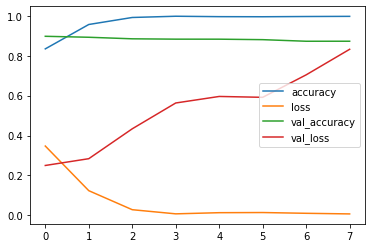

In [38]:
#print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'], label = "accuracy")
plt.plot(history.history['loss'], label = "loss")
plt.plot(history.history['val_accuracy'], label = "val_accuracy")
plt.plot(history.history['val_loss'], label = "val_loss")
plt.legend()
plt.show()

#### Investigating the missclassified results

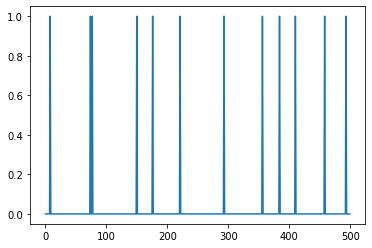

Review: 8
this movie was the most horrible movie watching experience i have ever had to endure and what is worse is the fact that i had to watch it and didn t have the opportunity to stop it because it was for school admittedly the storyline was decent but i found the acting terrible the exception was marianne jean baptiste i thought her performance was wonderful she was the only highlight without her i doubt i would have been able to bear watching the film every time i hear somebody say daarling i cringe i nearly attacked a customer the other day because they said it it made me remember one of the worst one and a half hours of my life br br i apologise if this has offended anybody i am only expressing my opinion
Correct: 0 Prediction: 1
False positive
********************
Review: 74
skip all the subjective this is a great film reviews and read the imdb trailer or the back the kino videobox which includes both versions of this flick which i ll paraphrase to the tune of sci fi score by 

/var/folders/5v/wrnrfs9x5z30cjvp_ytqb1pc0000gn/T/ipykernel_52452/3450100622.py:7: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  wrong_class=[X_train_text[i] for i in difference]


In [39]:
amount = 500
ypred = (hypermodel(X_train[:amount]).numpy() > 0.5).astype(int).reshape(amount)
difference =  ypred != y_train[:amount]
plt.plot(difference)
plt.show()
wrong_idx = list(np.where(difference)[0])
wrong_class=[X_train_text[i] for i in difference]
False_negative = 0
False_positive = 0
for i in range(0, len(wrong_idx)):
    
    print("Review:", wrong_idx[i])
    print(X_train_text[i])
    print("Correct:", y_train[wrong_idx[i]], "Prediction:",  ypred[wrong_idx[i]])
    if(y_train[wrong_idx[i]] == 1):
        print("False negative")
        False_negative += 1
    if(y_train[wrong_idx[i]] == 0):
        print("False positive")
        False_positive += 1
    print("********************")

5 7


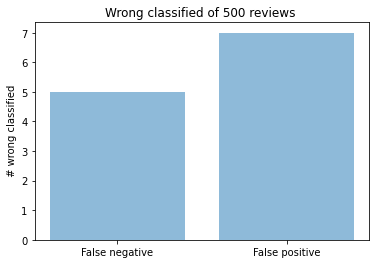

In [40]:
print(False_negative, False_positive)
objects = ('False negative', 'False positive')
y_pos = np.arange(len(objects))
performance = [False_negative, False_positive]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel(' # wrong classified')
plt.title(f'Wrong classified of {amount} reviews ')

plt.show()

### Conclusion of Task 2-b
The optimal parameters obtained in task 2-b were a word embedding dimension of 250 and 20 convolution filters together with a learning rate for the adam optimizer of 0.00065. Those are now used in task 2-c

In [8]:
WORD_EMBEDDING_DIM = 250
CONV_FILTERS = 20
LEARNING_RATE = 0.00065

## NLP Task 2-c
Task: In this step you will perform optimizations of the architecture. For this you will need to perform gridsearch
of several meta-parameters and hyper-parameters. The two most important meta-parameters are
W, or the number of convolution blocks in each layer and L, the number of consequetive convolution
layer. For simplicity, you can keep the architecture symmetric. This means that there should be an equal
number of blocks in each layer and a single pooling layer of the same number of blocks directly after
that. The number of blocks in each layer should have incrementing kernels to capture n-grams of different
sizes. For example, if you choose 3 blocks, the first should have kernel of size 1, the second 2 and
the third 3. This way, they capture uni-grams, bi-grams and tri-grams respectively. You can of course
perform other optimizations like finding the number of consecutive dense layers (Figure 1 shows only
one for simplicity), comparing max-pooling against average-poling and global-pooling, etc. You will
report the optimal meta-parameters and hyper-parameters that you found and the highest classification
accuracy score that you reached.

### Our approach:

We shifted some work of this part to task 2-b and extensively optimized parameters there, which we now use is the more elaborate model of task 2-c. Here, the function set_eleborate_mode(...) can create a convolutional neural network according to the task specification with an arbitrary depth of layers (L) and parallel convulution layers (W). Because we kept the parameters obtained by grid search in task 2-b constant, we could do an extensive grid search over L and W here. Additionally, because we obtained higher accuracies with higher kernel sizes (and especially bad ones with kernel size 1), we also chose to start with a kernel size of two rather than one.

In [9]:
def set_elaborate_model(vocabulary, word_embedding_dim, uniform_length, conv_filters, W, L):
    inputs = Input(shape=(uniform_length,))
    x = Embedding(vocabulary, word_embedding_dim, input_length=uniform_length)(inputs)
    
    #convolutional layers
    for l in range (L):
        c = []
        for w in range(W):
            if l == 0:
                c.append(Conv1D(filters=conv_filters, kernel_size=w+2, activation='relu')(x))
            else:
                c.append(Conv1D(filters=conv_filters, kernel_size=w+2, activation='relu')(p[w]))
        p = []
        for w in range(W):    
            p.append(MaxPooling1D(pool_size=POOL_SIZE)(c[w]))

    x = Concatenate(axis=1)(p)
    x = Flatten()(x)
    x = Dense (100, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

Here, we are doing a first test run with W=2 and L=2:

In [13]:
elaborate_model = set_elaborate_model(VOCABULARY, WORD_EMBEDDING_DIM, UNIFORM_LENGTH, CONV_FILTERS, 2, 2)
history = elaborate_model.fit (X_train, y_train, batch_size=BATCH_SIZE, epochs=2, validation_data=(X_test, y_test))

Epoch 1/2
2500/2500 [==============================] - 181s 72ms/step - loss: 0.3226 - accuracy: 0.8501 - val_loss: 0.2507 - val_accuracy: 0.8968
Epoch 2/2
2500/2500 [==============================] - 179s 71ms/step - loss: 0.1327 - accuracy: 0.9527 - val_loss: 0.2675 - val_accuracy: 0.8987


In [14]:
print (history.history['val_accuracy'][-1])

0.8986999988555908


Because the following grid search takes a lot of time (especially the large networks take quite a lot of time to train and evaluate), we tried, if we could get away with a larger batch size:

In [14]:
BATCH_SIZE = 64

In [16]:
elaborate_model = set_elaborate_model(VOCABULARY, WORD_EMBEDDING_DIM, UNIFORM_LENGTH, CONV_FILTERS, 2, 2)
history = elaborate_model.fit (X_train, y_train, batch_size=BATCH_SIZE, epochs=2, validation_data=(X_test, y_test))

Epoch 1/2
625/625 [==============================] - 76s 121ms/step - loss: 0.3443 - accuracy: 0.8318 - val_loss: 0.2572 - val_accuracy: 0.8966
Epoch 2/2
625/625 [==============================] - 76s 122ms/step - loss: 0.1377 - accuracy: 0.9504 - val_loss: 0.2684 - val_accuracy: 0.8943


As we are very insensitive to a larger batch size, we will continue the grid search over W and L with batch size 64.

In [17]:
# grid search for W and L

W = [2, 3, 4, 5]
L = [2, 3, 4]

for w in W:
    for l in L:
            elaborate_model = set_elaborate_model(VOCABULARY, WORD_EMBEDDING_DIM, UNIFORM_LENGTH, CONV_FILTERS, w, l)
            history = elaborate_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=2, validation_data=(X_test, y_test))
            print (f"Validation Accuracy with W={w} and L={l}: {history.history['val_accuracy'][-1]}.")

Epoch 1/2
625/625 [==============================] - 76s 121ms/step - loss: 0.3505 - accuracy: 0.8302 - val_loss: 0.2426 - val_accuracy: 0.9027
Epoch 2/2
625/625 [==============================] - 75s 120ms/step - loss: 0.1369 - accuracy: 0.9503 - val_loss: 0.2633 - val_accuracy: 0.8977
Validation Accuracy with W=2 and L=2: 0.8977000117301941.
Epoch 1/2
625/625 [==============================] - 75s 119ms/step - loss: 0.3843 - accuracy: 0.8025 - val_loss: 0.2586 - val_accuracy: 0.8916
Epoch 2/2
625/625 [==============================] - 74s 119ms/step - loss: 0.1550 - accuracy: 0.9431 - val_loss: 0.2684 - val_accuracy: 0.8917
Validation Accuracy with W=2 and L=3: 0.891700029373169.
Epoch 1/2
625/625 [==============================] - 77s 121ms/step - loss: 0.3856 - accuracy: 0.8087 - val_loss: 0.2690 - val_accuracy: 0.8915
Epoch 2/2
625/625 [==============================] - 74s 119ms/step - loss: 0.1634 - accuracy: 0.9392 - val_loss: 0.3340 - val_accuracy: 0.8719
Validation Accuracy w

The validation accuracy ranged from 87.19% to 90.22%. The best one was accomplished with W=4, L=3.

As a first try to find a superior architecture, we tried average pooling instead of max pooling:

In [20]:
# Average Pooling
def set_elaborate_model_avg(vocabulary, word_embedding_dim, uniform_length, conv_filters, W, L):
    inputs = Input(shape=(uniform_length,))
    x = Embedding(vocabulary, word_embedding_dim, input_length=uniform_length)(inputs)
    
    #convolutional layers
    for l in range (L):
        c = []
        for w in range(W):
            if l == 0:
                c.append(Conv1D(filters=conv_filters, kernel_size=w+2, activation='relu')(x))
            else:
                c.append(Conv1D(filters=conv_filters, kernel_size=w+2, activation='relu')(p[w]))
        p = []
        for w in range(W):    
            p.append(AveragePooling1D(pool_size=POOL_SIZE)(c[w]))

    x = Concatenate(axis=1)(p)
    x = Flatten()(x)
    x = Dense (100, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [21]:
elaborate_model = set_elaborate_model_avg(VOCABULARY, WORD_EMBEDDING_DIM, UNIFORM_LENGTH, CONV_FILTERS, 4, 3)
history = elaborate_model.fit (X_train, y_train, batch_size=BATCH_SIZE, epochs=2, validation_data=(X_test, y_test))

Epoch 1/2
625/625 [==============================] - 129s 204ms/step - loss: 0.3344 - accuracy: 0.8436 - val_loss: 0.2492 - val_accuracy: 0.8986
Epoch 2/2
625/625 [==============================] - 127s 204ms/step - loss: 0.1499 - accuracy: 0.9455 - val_loss: 0.2481 - val_accuracy: 0.9002


As avaerage pooling doesn't help too improve, we stick with max pooling. With the grid search part done and only looking for final optimizations, we go back to a batch size of 16 and are now doing 10 epochs to what our optimal validation accuracy will be:

In [10]:
BATCH_SIZE = 16

In [24]:
elaborate_model = set_elaborate_model(VOCABULARY, WORD_EMBEDDING_DIM, UNIFORM_LENGTH, CONV_FILTERS, 4, 3)
history = elaborate_model.fit (X_train, y_train, batch_size=BATCH_SIZE, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
2500/2500 [==============================] - 249s 99ms/step - loss: 0.3114 - accuracy: 0.8598 - val_loss: 0.2734 - val_accuracy: 0.8839
Epoch 2/10
2500/2500 [==============================] - 247s 99ms/step - loss: 0.1476 - accuracy: 0.9465 - val_loss: 0.2621 - val_accuracy: 0.9007
Epoch 3/10
2500/2500 [==============================] - 241s 96ms/step - loss: 0.0690 - accuracy: 0.9763 - val_loss: 0.3290 - val_accuracy: 0.8934
Epoch 4/10
2500/2500 [==============================] - 241s 96ms/step - loss: 0.0327 - accuracy: 0.9892 - val_loss: 0.5178 - val_accuracy: 0.8818
Epoch 5/10
2500/2500 [==============================] - 253s 101ms/step - loss: 0.0171 - accuracy: 0.9943 - val_loss: 0.5966 - val_accuracy: 0.8853
Epoch 6/10
2500/2500 [==============================] - 254s 102ms/step - loss: 0.0157 - accuracy: 0.9946 - val_loss: 0.6068 - val_accuracy: 0.8847
Epoch 7/10
2500/2500 [==============================] - 241s 96ms/step - loss: 0.0093 - accuracy: 0.9967 - val_loss:

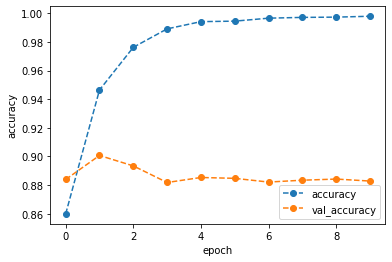

In [25]:
plt.plot(history.history['accuracy'], label = "accuracy", linestyle='--', marker='o')
plt.plot(history.history['val_accuracy'], label = "val_accuracy", linestyle='--', marker='o')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

We can clearly see, that our model is powerfull enough to fit the data, but it suffers from overfitting. We now try to tackle that problem by adding regularization to the Convolutional and Dense layers. Additionally a Dropout layers is added. We also repplaced the relu activation function with a slightly leaky relu.

In [11]:
def set_elaborate_model_reg(vocabulary, word_embedding_dim, uniform_length, conv_filters, W, L):
    inputs = Input(shape=(uniform_length,))
    x = Embedding(vocabulary, word_embedding_dim, input_length=uniform_length)(inputs)

    #convolutional layers
    for l in range (L):
        c = []
        for w in range(W):
            if l == 0:
                c.append (Conv1D(filters=conv_filters, kernel_size=w+2, activation=LeakyReLU(alpha=0.1),
                          kernel_regularizer=l2(3e-4),
                          bias_regularizer=l2(3e-4),
                          activity_regularizer=l2(3e-4))(x))
            else:
                c.append (Conv1D(filters=conv_filters, kernel_size=w+2, activation=LeakyReLU(alpha=0.1),
                          kernel_regularizer=l2(3e-4),
                          bias_regularizer=l2(3e-4),
                          activity_regularizer=l2(3e-4))(p[w-1]))
        p = []
        for w in range(W):    
            p.append (MaxPooling1D(pool_size=POOL_SIZE)(c[w]))

    x = Concatenate(axis=1)(p)
    x = Flatten()(x)
    x = Dense (1000, activation=LeakyReLU(alpha=0.1), activity_regularizer=l2(1e-2))(x)
    x = Dropout (0.4)(x)
    x = Dense (100, activation=LeakyReLU(alpha=0.1), activity_regularizer=l2(1e-2))(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)
    plot_model(model, to_file='elaborate_model_reg.png', show_shapes=True)
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [12]:
elaborate_model = set_elaborate_model_reg(VOCABULARY, WORD_EMBEDDING_DIM, UNIFORM_LENGTH, CONV_FILTERS, 4, 3)
history = elaborate_model.fit (X_train, y_train, batch_size=BATCH_SIZE, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
2500/2500 [==============================] - 301s 120ms/step - loss: 0.3874 - accuracy: 0.8547 - val_loss: 0.3064 - val_accuracy: 0.8925
Epoch 2/10
2500/2500 [==============================] - 307s 123ms/step - loss: 0.1973 - accuracy: 0.9452 - val_loss: 0.3245 - val_accuracy: 0.8914
Epoch 3/10
2500/2500 [==============================] - 289s 116ms/step - loss: 0.1234 - accuracy: 0.9727 - val_loss: 0.3674 - val_accuracy: 0.8868
Epoch 4/10
2500/2500 [==============================] - 282s 113ms/step - loss: 0.0897 - accuracy: 0.9836 - val_loss: 0.4515 - val_accuracy: 0.8782
Epoch 5/10
2500/2500 [==============================] - 267s 107ms/step - loss: 0.0749 - accuracy: 0.9882 - val_loss: 0.4776 - val_accuracy: 0.8793
Epoch 6/10
2500/2500 [==============================] - 271s 109ms/step - loss: 0.0715 - accuracy: 0.9890 - val_loss: 0.4182 - val_accuracy: 0.8848
Epoch 7/10
2500/2500 [==============================] - 269s 108ms/step - loss: 0.0651 - accuracy: 0.9910 - val_

In [ ]:
plt.plot(history.history['accuracy'], label = "accuracy", linestyle='--', marker='o')
plt.plot(history.history['val_accuracy'], label = "val_accuracy", linestyle='--', marker='o')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

Unfortunately, we were not able to find a regularized version of our network that performs better. Therefore, the unregularized version was the best CNN according to the specifications of the task specifications, that we could obtain.

### Best Model and Parameters
The architecture of our best model can be seen in the following picture:

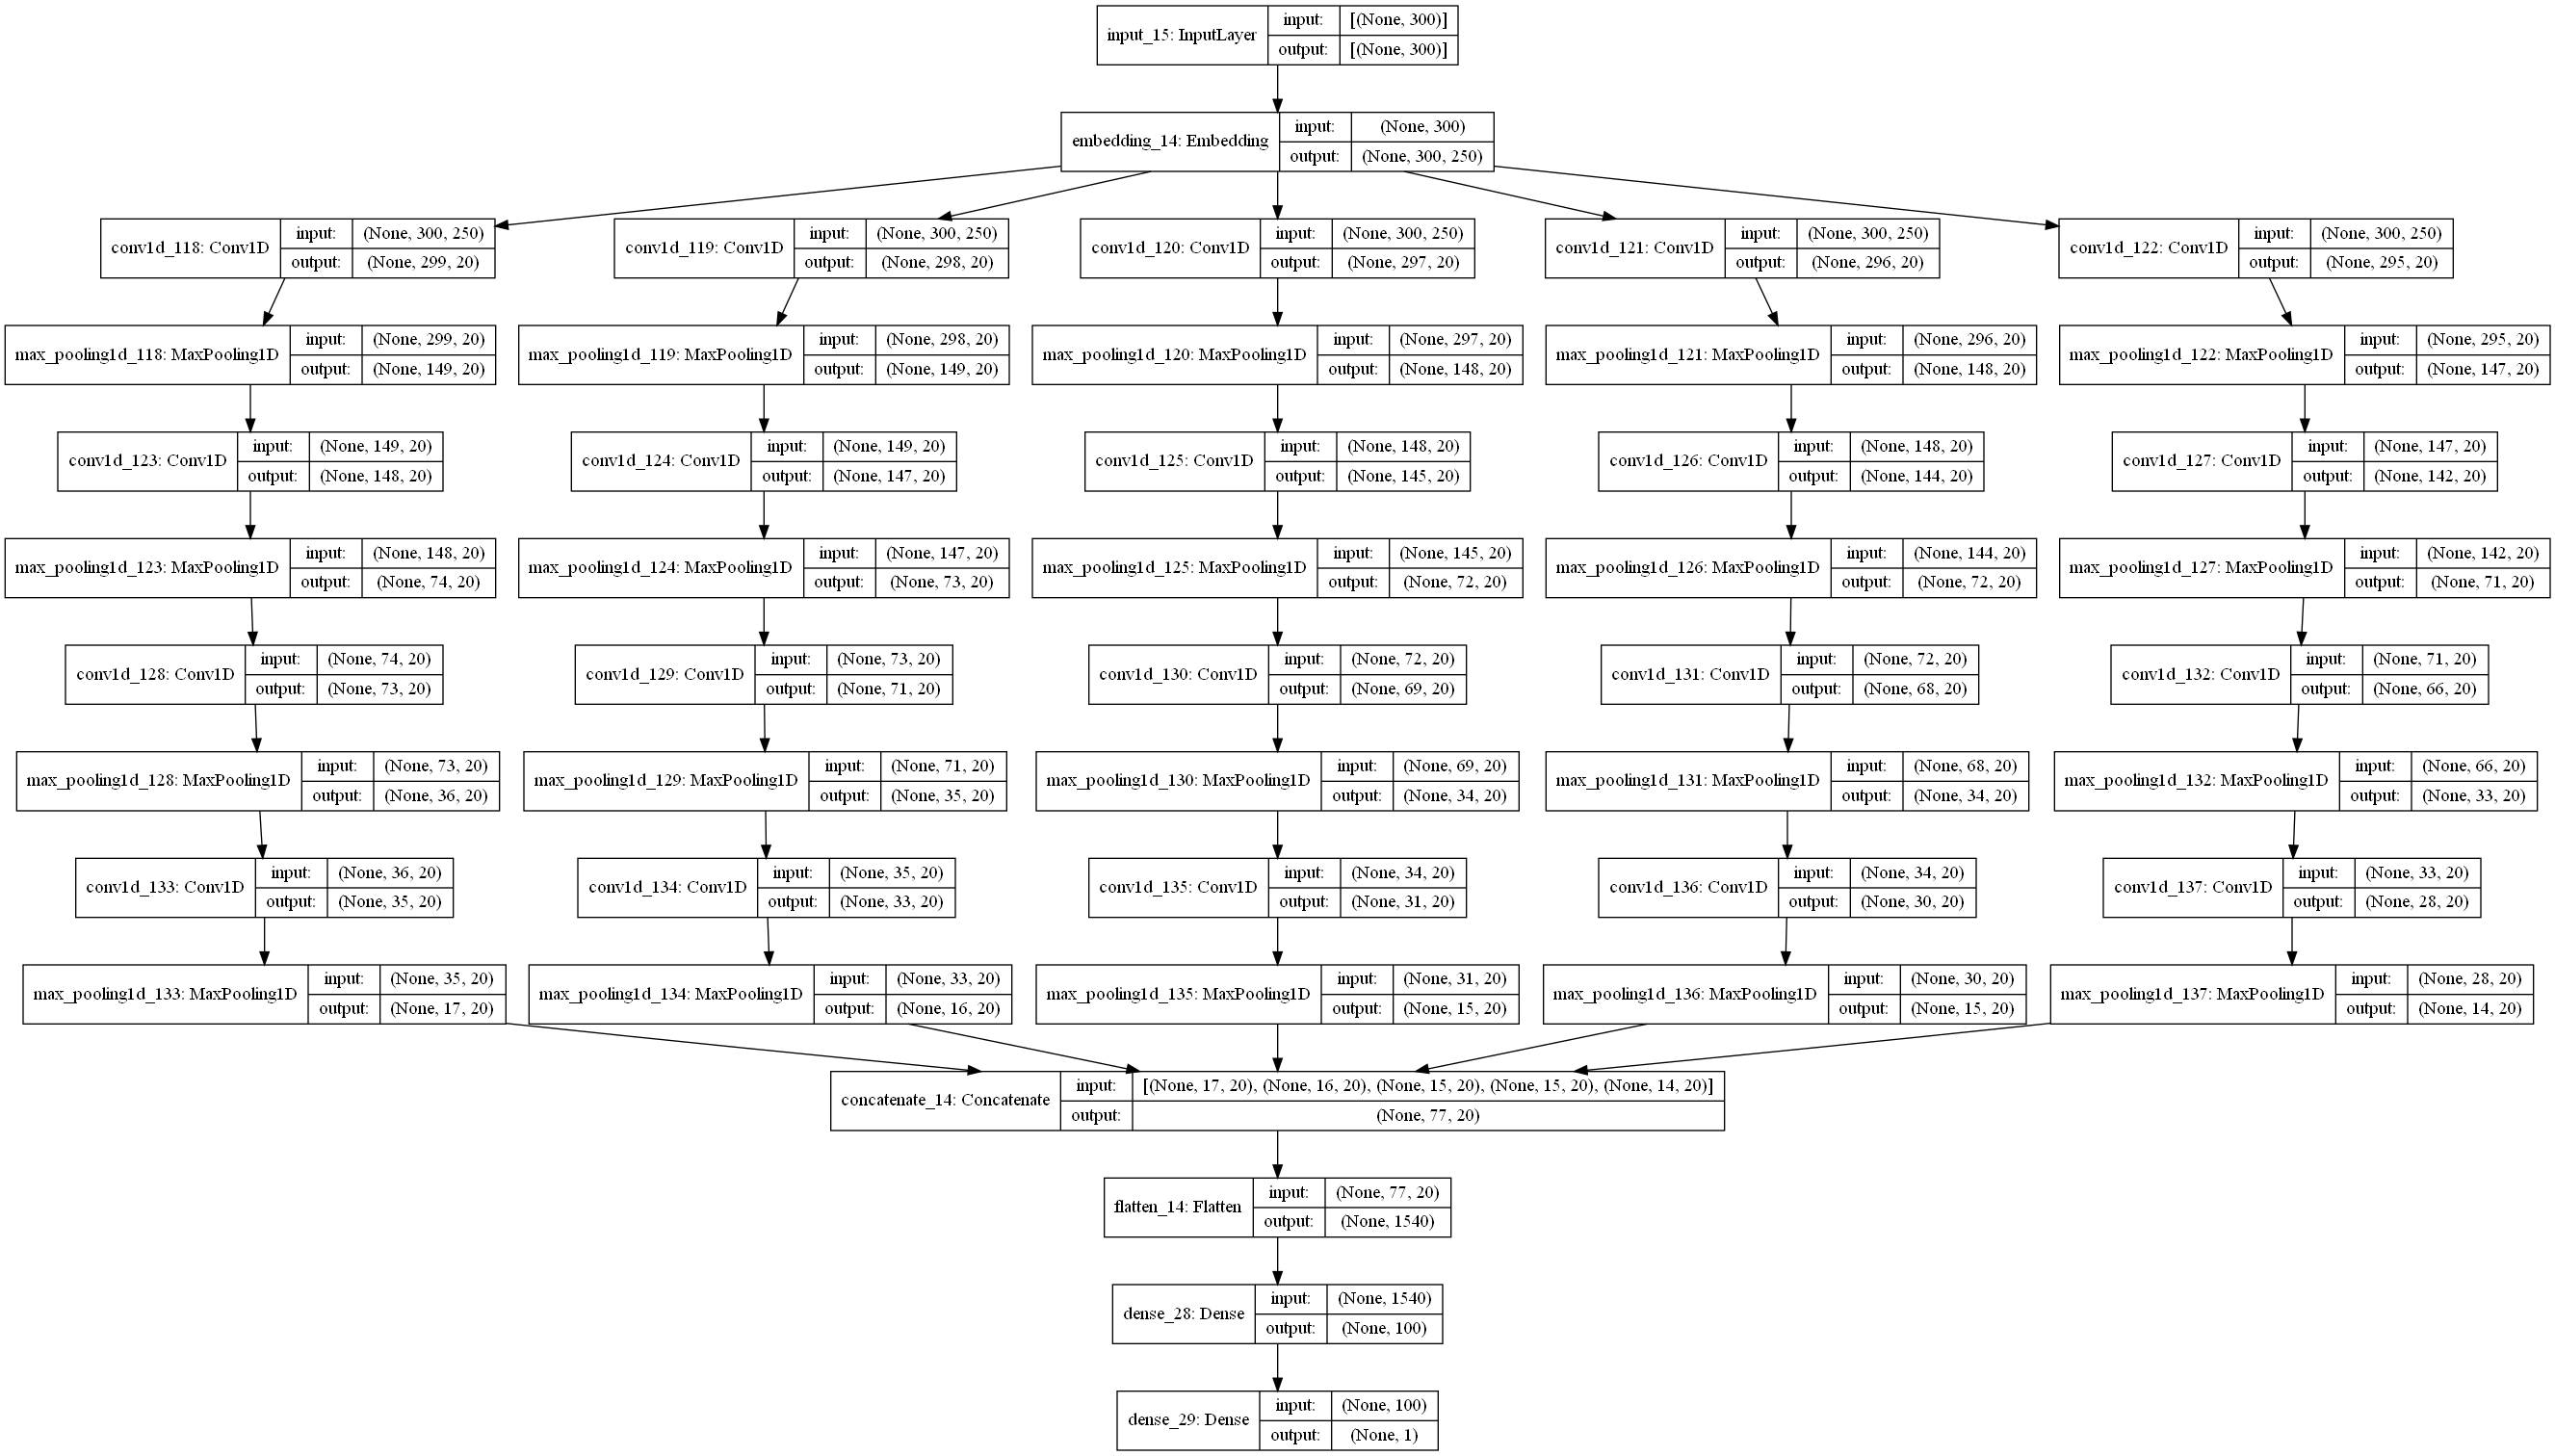

In [17]:
Image("elaborate_model.png")

That model achieved a validation accuracy of __90.22%__

Word embedding dimension: 250 <br>
Max length of the review sequence: 300 <br>
Convolution filters: 20 <br>
W (width of the convolutional part): 4 <br>
L (depth of the convolutional parT): 3 <br>
Kernel size: 2 - 5 <br>
Train/test split: 1:4 <br>
Learning rate of adam optimizer: 0.00065 <br>

We used max pooling after each convolutional layer and one dense layer before the output layer. ReLu was used as activation function, except for the output layer, which used sigmoid.